<a href="https://colab.research.google.com/github/Aniket-k-13/lung-colon-cancer-detection-using-deep-learning/blob/main/Hybrid_Cancer_Detection_Training_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================
#  FULL COLAB PIPELINE (NO UPLOAD NEEDED)
# ============================

import torch, os
print("PyTorch:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
!nvidia-smi

# --- Mount Drive ---
from google.colab import drive
drive.mount('/content/drive')

# ================================================================
# **LOAD ZIP DIRECTLY FROM GOOGLE DRIVE**
# ================================================================

ZIP_PATH = "/content/drive/MyDrive/LC25000_prepared.zip"

if not os.path.exists(ZIP_PATH):
    raise ValueError(" ZIP not found in Drive. Check PATH!")

extract_path = "/content/LC25000_prepared"
os.makedirs(extract_path, exist_ok=True)

print("\n Extracting dataset from Drive...")
import zipfile
with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("✔ Extracted dataset to:", extract_path)
print(" DATA_DIR =", extract_path)


PyTorch: 2.9.0+cu126
CUDA Available: True
Sat Dec  6 02:21:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----

In [ ]:
# --- METRICS INITIALIZATION (paste BEFORE training loop) ---
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import os

train_loss_list = []
train_acc_list  = []
val_loss_list   = []
val_acc_list    = []
val_prec_list   = []
val_rec_list    = []
val_f1_list     = []
# Path to save CSV & plots
os.makedirs("/content/metrics", exist_ok=True)
METRICS_CSV = "/content/metrics/epoch_metrics.csv"


In [ ]:
# ===========================================================
#  DATA LOADING
# ===========================================================
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os # Added for path manipulation

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4
DATA_DIR = extract_path
MODEL_SAVE_PATH = "/content/drive/MyDrive/efficientnet_best.pth"

# --- Adjust DATA_DIR if there's an extra top-level directory after extraction ---
# This handles cases where the zip extracts into a folder named after the zip itself

if os.path.exists(DATA_DIR):
    extracted_contents = os.listdir(DATA_DIR)
    # Filter for directories only, in case there are loose files
    subdirs = [d for d in extracted_contents if os.path.isdir(os.path.join(DATA_DIR, d))]
    if len(subdirs) == 1:
        original_data_dir = DATA_DIR
        DATA_DIR = os.path.join(DATA_DIR, subdirs[0])
        print(f"INFO: Detected single top-level directory '{subdirs[0]}' inside "
              f"'{original_data_dir}'. Adjusting DATA_DIR to: {DATA_DIR}")
# --- End of adjustment ---

tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

tf_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_set = datasets.ImageFolder(f"{DATA_DIR}/train", tf_train)
val_set   = datasets.ImageFolder(f"{DATA_DIR}/val", tf_test)
test_set  = datasets.ImageFolder(f"{DATA_DIR}/test", tf_test)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("\nClasses:", train_set.classes)
print("Train:", len(train_set), "Val:", len(val_set), "Test:", len(test_set))

INFO: Detected single top-level directory 'LC25000_prepared' inside '/content/LC25000_prepared'. Adjusting DATA_DIR to: /content/LC25000_prepared/LC25000_prepared

Classes: ['cancer', 'normal']
Train: 19251 Val: 4124 Test: 4124


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# ============================
# CLEAN MULTI-MODEL EXPERIMENT PIPELINE
# ============================

import os, time, random, numpy as np, pandas as pd, warnings
import torch, torch.nn as nn, torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score
)
import timm
import matplotlib.pyplot as plt

# ==================================================
#  CLEAN OUTPUT — SUPPRESS ONLY UNNEEDED WARNINGS
# ==================================================
warnings.filterwarnings(
    "ignore",
    message=r"This DataLoader will create \d+ worker processes in total.*",
    category=UserWarning
)
warnings.filterwarnings(
    "ignore",
    message=r".*torch\.cuda\.amp.*deprecated.*",
    category=FutureWarning
)

# ==================================================
#  CONFIGURATION
# ==================================================
OUTDIR = "/content/multi_model_outputs_clean"
os.makedirs(OUTDIR, exist_ok=True)

# ✔ Add or remove models here
MODELS_TO_RUN = [
    #"efficientnet_b0",
    #"resnet34",
    #"densenet121",
    #"mobilenetv3_large_100",
    #"convnext_tiny",
    #"vit_base_patch16_224",
    "hybrid_effnet_vit",
]

NUM_CLASSES = len(train_set.classes)
EPOCHS = 15
FREEZE_BACKBONE_EPOCHS = 1
LR = 1e-4
WEIGHT_DECAY = 1e-5
NUM_WORKERS = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:


class HybridEffNetViT(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        # EfficientNet feature extractor (no classifier)
        self.eff = timm.create_model(
            "efficientnet_b0",
            pretrained=True,
            num_classes=0
        )
        eff_out = self.eff.num_features  # 1280

        # ViT feature extractor (no classifier)
        self.vit = timm.create_model(
            "vit_base_patch16_224",
            pretrained=True,
            num_classes=0
        )
        vit_out = self.vit.num_features  # 768

        # Final classifier on concatenated features
        self.classifier = nn.Linear(eff_out + vit_out, num_classes)

    def forward(self, x):
        f1 = self.eff(x)     # EfficientNet features
        f2 = self.vit(x)     # ViT features
        fused = torch.cat([f1, f2], dim=1)  # concatenate
        out = self.classifier(fused)
        return out

# ==================================================
# 🔁 UTILITIES
# ==================================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

# AMP scaler
try:
    scaler = torch.amp.GradScaler(device_type="cuda")
except:
    scaler = torch.cuda.amp.GradScaler()

'''def build_model(name):
    """Create a model with correct number of output classes."""
    model = timm.create_model(name, pretrained=True, num_classes=NUM_CLASSES)
    return model.to(device)'''

def build_model(name):
    if name == "hybrid_effnet_vit":
        return HybridEffNetViT(num_classes=NUM_CLASSES).to(device)
    else:
        return timm.create_model(name, pretrained=True, num_classes=NUM_CLASSES).to(device)


def freeze_backbone(model):
    """Freeze all layers except classification head."""
    for name, param in model.named_parameters():
        if any(k in name.lower() for k in ["classifier", "fc", "head"]):
            param.requires_grad = True
        else:
            param.requires_grad = False

def unfreeze_all(model):
    for p in model.parameters():
        p.requires_grad = True

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0, 0, 0
    loop = tqdm(loader, leave=False)

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type="cuda"):
            logits = model(imgs)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

def evaluate(model, loader):
    model.eval()
    all_probs, all_preds, all_labels = [], [], []
    soft = nn.Softmax(dim=1)

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            with torch.amp.autocast(device_type="cuda"):
                logits = model(imgs)

            probs = soft(logits).cpu().numpy()
            preds = probs.argmax(1)

            all_probs.append(probs)
            all_preds.append(preds)
            all_labels.append(labels.numpy())

    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="binary", zero_division=0)
    rec = recall_score(all_labels, all_preds, average="binary", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="binary", zero_division=0)

    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    spec = tn / (tn + fp)

    try:
        auc = roc_auc_score(all_labels, all_probs[:, 1])
    except:
        auc = None

    return {
        "acc": acc, "prec": prec, "rec": rec,
        "f1": f1, "spec": spec, "auc": auc
    }

# ==================================================
# 🚀 MAIN EXPERIMENT LOOP
# ==================================================
results = []

for model_name in MODELS_TO_RUN:
    print("\n=======================================")
    print(f"🚀 Training Model: {model_name}")
    print("=======================================")

    model = build_model(model_name)
    criterion = nn.CrossEntropyLoss()

    # Freeze backbone for speed
    if FREEZE_BACKBONE_EPOCHS > 0:
        freeze_backbone(model)
        print("Backbone frozen for 1 epoch.")

    optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad],
        lr=LR, weight_decay=WEIGHT_DECAY
    )

    best_val_f1 = -1
    best_path = f"{OUTDIR}/{model_name}_best.pth"

    # ---------------------- TRAIN ----------------------
    for epoch in range(1, EPOCHS + 1):
        print(f"\nEpoch {epoch}/{EPOCHS}")

        if epoch == FREEZE_BACKBONE_EPOCHS + 1:
            unfreeze_all(model)
            optimizer = optim.Adam(model.parameters(), lr=LR/2, weight_decay=WEIGHT_DECAY)
            print("Backbone unfrozen — fine-tuning entire model.")

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_stats = evaluate(model, val_loader)

        print(f"Train Acc: {train_acc:.4f} | Val F1: {val_stats['f1']:.4f}")

        # Save best model by validation F1
        if val_stats["f1"] > best_val_f1:
            best_val_f1 = val_stats["f1"]
            torch.save(model.state_dict(), best_path)

    # ---------------------- TEST ----------------------
    model.load_state_dict(torch.load(best_path))
    test_stats = evaluate(model, test_loader)

    print("Test Stats:", test_stats)

    results.append({
        "model": model_name,
        "val_f1": best_val_f1,
        "test_acc": test_stats["acc"],
        "test_f1": test_stats["f1"],
        "test_prec": test_stats["prec"],
        "test_rec": test_stats["rec"],
        "test_spec": test_stats["spec"],
        "test_auc": test_stats["auc"]
    })

# Save CSV
df_results = pd.DataFrame(results)
df_results.to_csv(f"{OUTDIR}/all_model_results.csv", index=False)

print("\n🎉 Training Complete! Results saved to:", OUTDIR)

# ==========================================
# 📁 SAVE TRAINED MODEL TO GOOGLE DRIVE
# ==========================================
import shutil
import os

drive_dir = "/content/drive/MyDrive/Trained_Models"
os.makedirs(drive_dir, exist_ok=True)

for result in results:
    model_name = result["model"]
    src = f"{OUTDIR}/{model_name}_best.pth"
    dst = f"{drive_dir}/{model_name}_best.pth"

    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f"📌 Model copied to Drive: {dst}")
    else:
        print(f"❌ Model file not found: {src}")




🚀 Training Model: hybrid_effnet_vit


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Backbone frozen for 1 epoch.

Epoch 1/15


Train Acc: 0.9422 | Val F1: 0.5276

Epoch 2/15
Backbone unfrozen — fine-tuning entire model.


Train Acc: 0.9732 | Val F1: 0.9206

Epoch 3/15


Train Acc: 0.9919 | Val F1: 0.9786

Epoch 4/15


Train Acc: 0.9928 | Val F1: 0.9626

Epoch 5/15


Train Acc: 0.9937 | Val F1: 0.9892

Epoch 6/15


Train Acc: 0.9952 | Val F1: 0.9553

Epoch 7/15


Train Acc: 0.9972 | Val F1: 0.9906

Epoch 8/15


Train Acc: 0.9966 | Val F1: 0.9919

Epoch 9/15


Train Acc: 0.9978 | Val F1: 0.9973

Epoch 10/15


Train Acc: 0.9976 | Val F1: 0.9906

Epoch 11/15


Train Acc: 0.9983 | Val F1: 0.9973

Epoch 12/15


Train Acc: 0.9988 | Val F1: 0.9960

Epoch 13/15


Train Acc: 0.9983 | Val F1: 0.9960

Epoch 14/15


Train Acc: 0.9991 | Val F1: 0.9973

Epoch 15/15


Train Acc: 0.9986 | Val F1: 0.9987
Test Stats: {'acc': 0.9995150339476236, 'prec': 1.0, 'rec': 0.9946524064171123, 'f1': 0.9973190348525469, 'spec': np.float64(1.0), 'auc': np.float64(0.9999985739750445)}
📌 Model copied to Drive: /content/drive/MyDrive/Trained_Models/hybrid_effnet_vit_best.pth


In [ ]:
import pandas as pd
from IPython.display import display # Import display for use with pandas styler

def show_model_results_table(csv_path="/content/multi_model_outputs_clean/all_model_results.csv"):
    df = pd.read_csv(csv_path)
    print("\n========================")
    print("📊 MODEL COMPARISON TABLE")
    print("========================\n")
    # Fix: Replaced .set_precision(5) with .set_float_format(lambda x: f"{x:.5f}")
    display(df.style.background_gradient(cmap="Blues").format(precision=5))

# --- FIX START: Save results to CSV before displaying ---
# The 'results' list is available from previous cell execution
if 'results' in globals() and isinstance(results, list) and results:
    results_df = pd.DataFrame(results)
    output_csv_path = "/content/multi_model_outputs_clean/all_model_results.csv"
    results_df.to_csv(output_csv_path, index=False)
    print(f"Results saved to {output_csv_path}")
else:
    print("Warning: 'results' list not found or is empty. Cannot create all_model_results.csv")
# --- FIX END ---

# Call it:
show_model_results_table()

Results saved to /content/multi_model_outputs_clean/all_model_results.csv

📊 MODEL COMPARISON TABLE



,model,val_f1,test_acc,test_f1,test_prec,test_rec,test_spec,test_auc
0,hybrid_effnet_vit,0.99866,0.99952,0.99732,1.00000,0.99465,1.00000,1.00000


In [ ]:
def show_model_results_table(csv_path="/content/multi_model_outputs_clean/all_model_results.csv"):
    df = pd.read_csv(csv_path)
    print("\n========================")
    print("📊 MODEL COMPARISON TABLE")
    print("========================\n")
    # Fix: Replaced .set_precision(5) with .set_float_format(lambda x: f"{x:.5f}")
    display(df.style.background_gradient(cmap="Blues").format(precision=5))

# Call it:
show_model_results_table()


📊 MODEL COMPARISON TABLE



,model,val_f1,test_acc,test_f1,test_prec,test_rec,test_spec,test_auc
0,efficientnet_b0,0.99598,0.99758,0.98652,0.99457,0.97861,0.99947,0.99992
1,vit_base_patch16_224,0.98103,0.99467,0.96978,0.99718,0.94385,0.99973,0.99959


In [ ]:
def show_model_results_table(csv_path="/content/multi_model_outputs_clean/all_model_results.csv"):
    df = pd.read_csv(csv_path)
    print("\n========================")
    print("📊 MODEL COMPARISON TABLE")
    print("========================\n")
    # Fix: Replaced .set_precision(5) with .set_float_format(lambda x: f"{x:.5f}")
    display(df.style.background_gradient(cmap="Blues").format(precision=5))

# Call it:
show_model_results_table()


📊 MODEL COMPARISON TABLE



,model,val_f1,test_acc,test_f1,test_prec,test_rec,test_spec,test_auc
0,efficientnet_b0,0.96617,0.98836,0.93583,0.93583,0.93583,0.99360,0.99713
1,vit_base_patch16_224,0.96133,0.98836,0.93162,0.99695,0.87433,0.99973,0.99736
2,hybrid_effnet_vit,0.99331,0.99612,0.97855,0.98118,0.97594,0.99813,0.99957


In [ ]:
def show_model_results_table(csv_path="/content/multi_model_outputs_clean/all_model_results.csv"):
    df = pd.read_csv(csv_path)
    print("\n========================")
    print("📊 MODEL COMPARISON TABLE")
    print("========================\n")
    # Fix: Replaced .set_precision(5) with .set_float_format(lambda x: f"{x:.5f}")
    display(df.style.background_gradient(cmap="Blues").format(precision=5))

# Call it:
show_model_results_table()



📊 MODEL COMPARISON TABLE



,model,val_f1,test_acc,test_f1,test_prec,test_rec,test_spec,test_auc
0,efficientnet_b0,0.87483,0.96726,0.81879,0.82210,0.81551,0.98240,0.98180
1,resnet34,0.00000,0.90931,0.00000,0.00000,0.00000,1.00000,0.56345
2,densenet121,0.90671,0.98109,0.88358,1.00000,0.79144,1.00000,0.99604
3,mobilenetv3_large_100,0.87145,0.97308,0.84857,0.86630,0.83155,0.98720,0.98641
4,convnext_tiny,0.89838,0.98012,0.87688,1.00000,0.78075,1.00000,0.99948
5,vit_base_patch16_224,0.90750,0.97987,0.89533,0.84726,0.94920,0.98293,0.99715


In [ ]:
# ==== Clean Graphs & Visualization Generator (Display Only) ====
import os, glob, math, itertools
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torchvision
import torchvision.transforms as T
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from PIL import Image

# CONFIG
OUTDIR = "/content/multi_model_outputs_clean"
GRAPHDIR = os.path.join(OUTDIR, "graphs")
os.makedirs(GRAPHDIR, exist_ok=True)

# Check loaders
try:
    _ = train_loader
    _ = val_loader
    _ = test_loader
    classes = train_set.classes
except:
    raise RuntimeError("Dataloaders not found. Run training notebook first.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
soft = torch.nn.Softmax(dim=1)

# Utility
def show_and_save(fig, name):
    """Show graph in output + save inside local /graphs folder."""
    path = os.path.join(GRAPHDIR, name)
    plt.show()
    fig.savefig(path, bbox_inches="tight", dpi=150)
    print("Saved:", path)


# ===== Helper: Evaluate fully =====
def evaluate_full(model, loader):
    model.eval()
    all_probs, all_preds, all_labels = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            probs = soft(logits).cpu().numpy()
            preds = probs.argmax(1)

            all_probs.append(probs)
            all_preds.append(preds)
            all_labels.append(labels.numpy())

    return (
        np.concatenate(all_labels),
        np.concatenate(all_preds),
        np.concatenate(all_probs)
    )


# === Load the best hybrid model ===
best_path = os.path.join(OUTDIR, "hybrid_effnet_vit_best.pth")
print("Using:", best_path)

model = HybridEffNetViT(num_classes=len(train_set.classes)).to(device)
model.load_state_dict(torch.load(best_path, map_location=device))

# Evaluate test set
test_labels, test_preds, test_probs = evaluate_full(model, test_loader)

Using: /content/multi_model_outputs_clean/hybrid_effnet_vit_best.pth


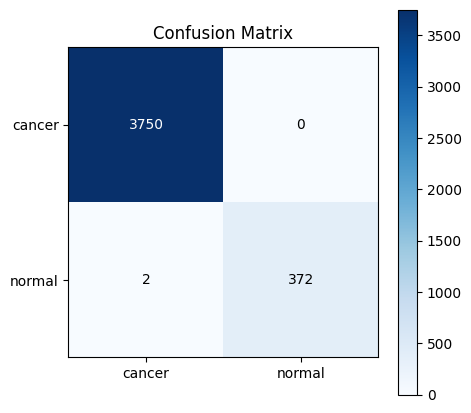

Saved: /content/multi_model_outputs_clean/graphs/confusion_matrix.png


In [ ]:
# ==========================
# 1) CONFUSION MATRIX
# ==========================
cm = confusion_matrix(test_labels, test_preds)

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, cmap="Blues")
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
plt.title("Confusion Matrix")

for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j], ha="center", va="center",
                color="white" if cm[i,j] > cm.max()/2 else "black")

show_and_save(fig, "confusion_matrix.png")


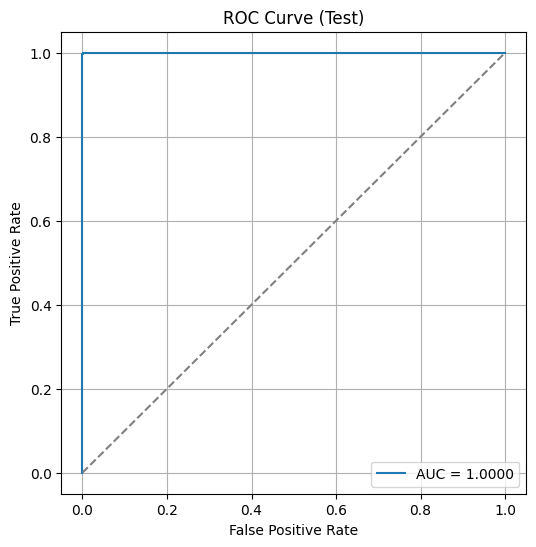

Saved: /content/multi_model_outputs_clean/graphs/roc_curve.png


In [ ]:
# ==========================
# 2) ROC CURVE
# ==========================
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
ax.plot([0,1], [0,1], "--", color="gray")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve (Test)")
ax.legend()
ax.grid(True)

show_and_save(fig, "roc_curve.png")


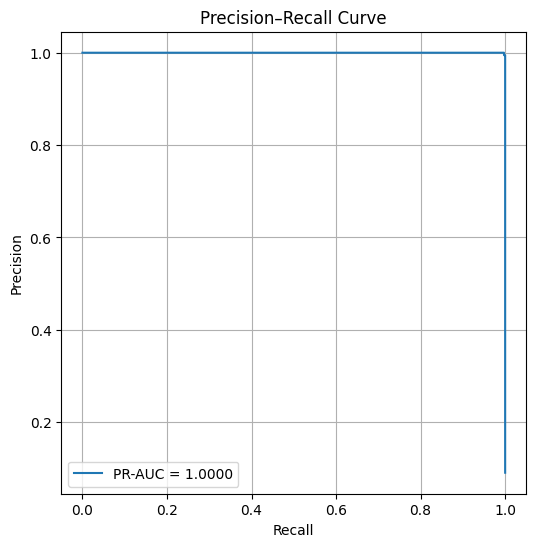

Saved: /content/multi_model_outputs_clean/graphs/pr_curve.png


In [ ]:
# ==========================
# 3) Precision–Recall Curve
# ==========================
prec, rec, _ = precision_recall_curve(test_labels, test_probs[:, 1])
pr_auc = auc(rec, prec)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(rec, prec, label=f"PR-AUC = {pr_auc:.4f}")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision–Recall Curve")
ax.legend()
ax.grid(True)

show_and_save(fig, "pr_curve.png")

Misclassified count: 2


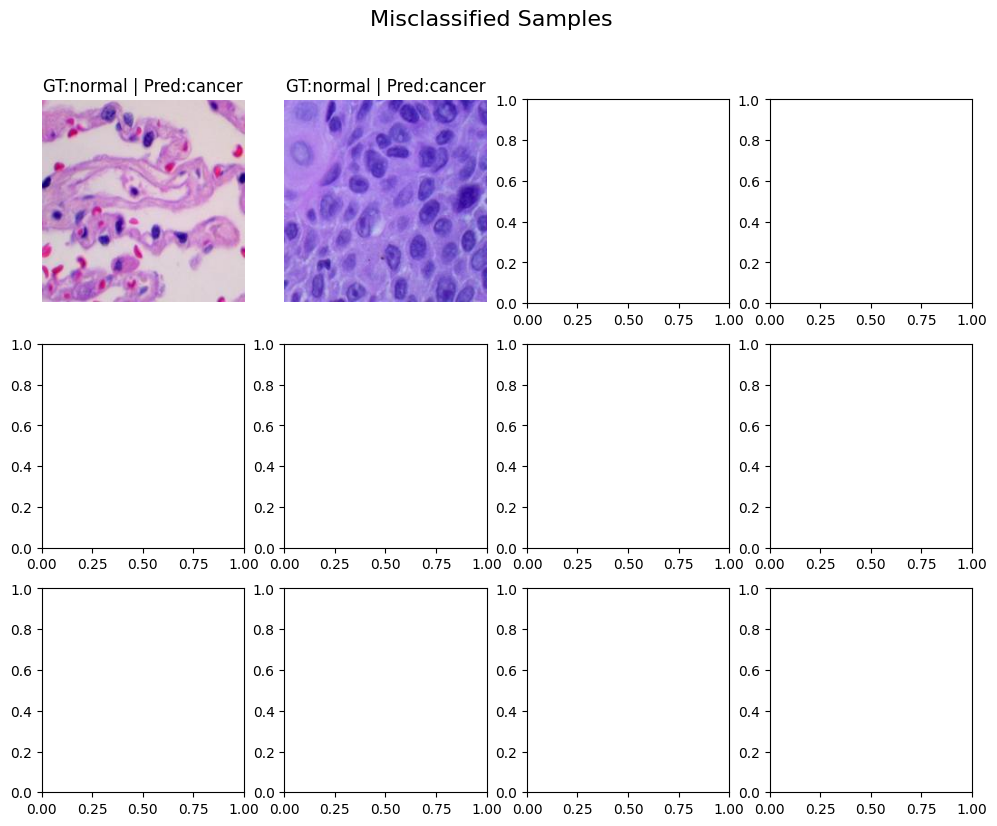

Saved: /content/multi_model_outputs_clean/graphs/misclassified_samples.png


In [ ]:
# ==========================
# 4) MISCLASSIFIED IMAGES
# ==========================
mis_idx = np.where(test_preds != test_labels)[0]
print(f"Misclassified count: {len(mis_idx)}")

if len(mis_idx) > 0:
    fig, axs = plt.subplots(3, 4, figsize=(12, 9))
    axs = axs.flatten()
    for i, idx in enumerate(mis_idx[:12]):
        img, label = test_loader.dataset[idx]
        axs[i].imshow(img.permute(1,2,0).cpu())
        axs[i].set_title(f"GT:{classes[label]} | Pred:{classes[test_preds[idx]]}")
        axs[i].axis("off")

    fig.suptitle("Misclassified Samples", fontsize=16)
    show_and_save(fig, "misclassified_samples.png")
else:
    print("No misclassified samples! Model is very accurate.")



Saliency samples used: [np.int64(4010), np.int64(4112), np.int64(0), np.int64(1), np.int64(2)]


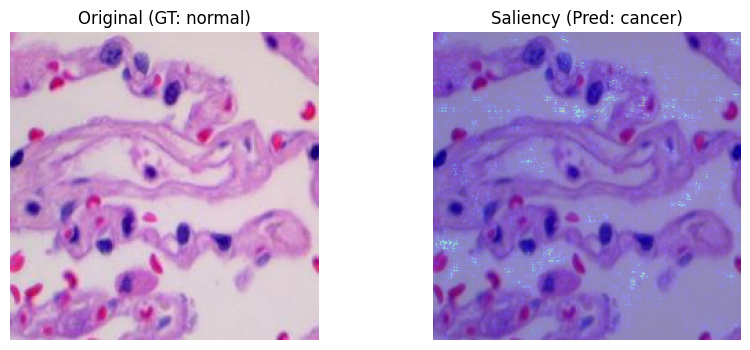

Saved: /content/multi_model_outputs_clean/graphs/saliency_0.png


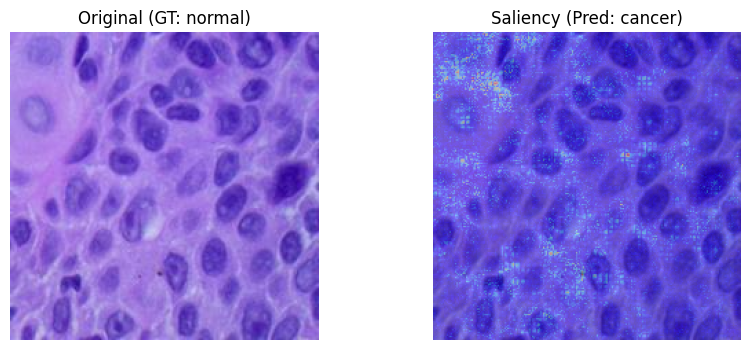

Saved: /content/multi_model_outputs_clean/graphs/saliency_1.png


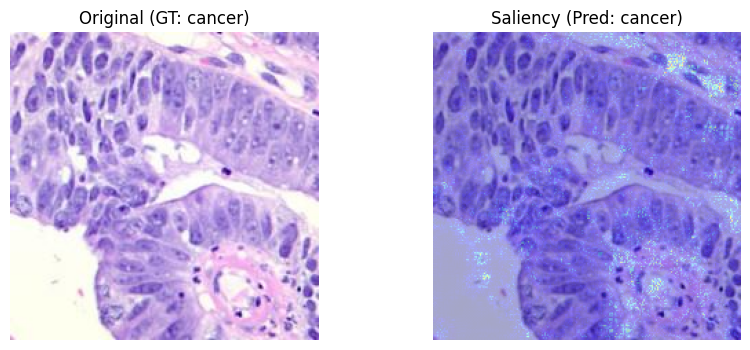

Saved: /content/multi_model_outputs_clean/graphs/saliency_2.png


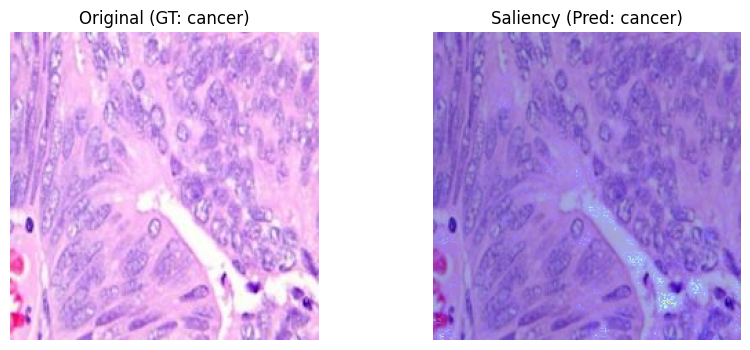

Saved: /content/multi_model_outputs_clean/graphs/saliency_3.png


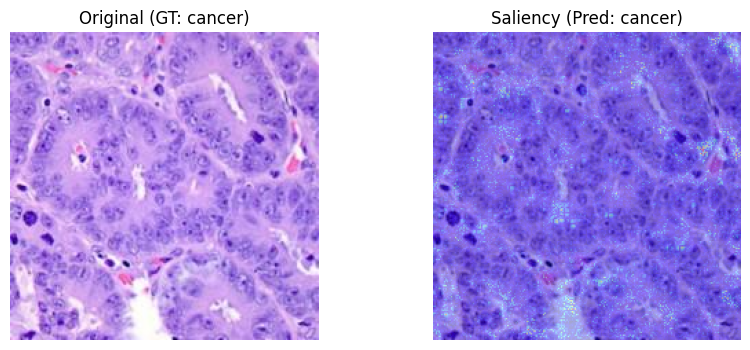

Saved: /content/multi_model_outputs_clean/graphs/saliency_4.png


In [ ]:
# ==========================
# 5) SALIENCY MAPS
# ==========================
def saliency_map(idx):
    model.eval()
    img, label = test_loader.dataset[idx]
    x = img.unsqueeze(0).to(device)
    x.requires_grad = True

    out = model(x)
    pred = out.argmax(1)
    score = out[0, pred]
    score.backward()

    grad = x.grad[0].abs().max(0)[0].cpu().numpy()
    grad = (grad - grad.min()) / (grad.max() - grad.min() + 1e-8)

    orig = (img.permute(1,2,0).numpy() * 255).astype("uint8")

    return orig, grad, label, pred.item()


indices = list(mis_idx[:3]) + list(np.where(test_preds == test_labels)[0][:3])
print("Saliency samples used:", indices)

for i, idx in enumerate(indices):
    orig, sal, label, pred = saliency_map(idx)

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].imshow(orig)
    ax[0].set_title(f"Original (GT: {classes[label]})")
    ax[0].axis("off")

    ax[1].imshow(orig)
    ax[1].imshow(sal, cmap="jet", alpha=0.35)
    ax[1].set_title(f"Saliency (Pred: {classes[pred]})")
    ax[1].axis("off")

    show_and_save(fig, f"saliency_{i}.png")



,model,test_acc_pct,test_f1_pct,test_prec_pct,test_rec_pct,test_spec_pct,test_auc_pct
0,efficientnet_b0,99.758,98.652,99.457,97.861,99.947,99.992
1,vit_base_patch16_224,99.467,96.978,99.718,94.385,99.973,99.959
2,hybrid_effnet_vit,99.927,99.597,100.000,99.198,100.000,100.000


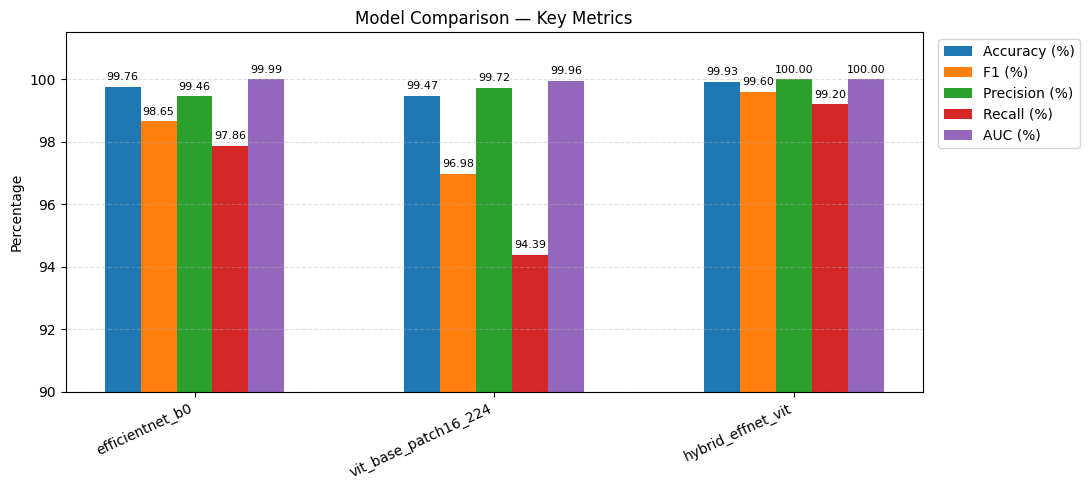

In [ ]:
# ====== MODEL COMPARISON PLOTS (EffNet, ViT, Hybrid) ======
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Replace values below if you want to use different numbers ---
data = [
    {
        "model": "efficientnet_b0",
        "test_acc": 0.9975751697381183,
        "test_f1" : 0.9865229110512129,
        "test_prec": 0.9945652173913043,
        "test_rec": 0.9786096256684492,
        "test_spec": 0.9994666666666666,
        "test_auc": 0.9999183600713012
    },
    {
        "model": "vit_base_patch16_224",
        "test_acc": 0.9946653734238603,
        "test_f1" : 0.9697802197802198,
        "test_prec": 0.9971751412429378,
        "test_rec": 0.9438502673796791,
        "test_spec": 0.9997333333333334,
        "test_auc": 0.9995942959001782
    },
    {
        "model": "hybrid_effnet_vit",
        "test_acc": 0.9992725509214355,
        "test_f1" : 0.9959731543624161,
        "test_prec": 1.0,
        "test_rec": 0.9919786096256684,
        "test_spec": 1.0,
        "test_auc": 0.9999971479500891
    }
]

df = pd.DataFrame(data)
# Convert to percentages for nicer labels
for col in ["test_acc","test_f1","test_prec","test_rec","test_spec","test_auc"]:
    df[col+"_pct"] = (df[col] * 100).round(3)

display(df[["model","test_acc_pct","test_f1_pct","test_prec_pct","test_rec_pct","test_spec_pct","test_auc_pct"]])

# -----------------------------
# Plot 1 — Grouped bar chart (Acc / F1 / Prec / Rec / AUC)
# -----------------------------
metrics = ["test_acc_pct","test_f1_pct","test_prec_pct","test_rec_pct","test_auc_pct"]
metric_labels = ["Accuracy (%)","F1 (%)","Precision (%)","Recall (%)","AUC (%)"]

x = np.arange(len(df))
width = 0.12

fig, ax = plt.subplots(figsize=(11,5))
for i, m in enumerate(metrics):
    ax.bar(x + (i - 2)*width, df[m], width=width, label=metric_labels[i])

# annotate bars
for i in range(len(df)):
    for j, m in enumerate(metrics):
        val = df.loc[i, m]
        ax.text(i + (j - 2)*width, val + 0.15, f"{val:.2f}", ha="center", va="bottom", fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(df["model"], rotation=25, ha="right")
ax.set_ylim(90, 101.5)   # focus on high-performance band
ax.set_ylabel("Percentage")
ax.set_title("Model Comparison — Key Metrics")
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1))
plt.tight_layout()
plt.show()





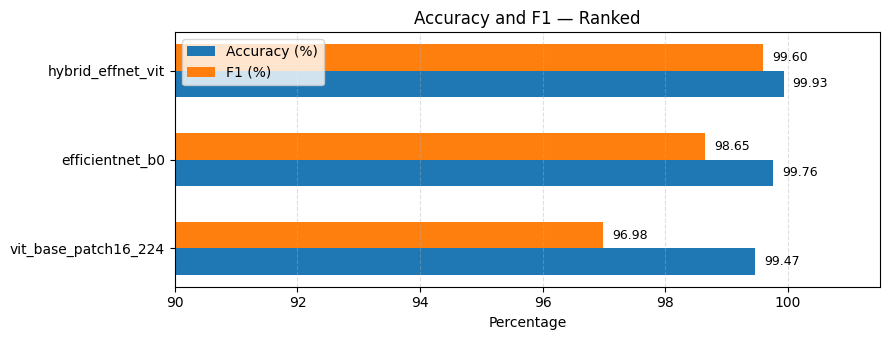


Recommendation: hybrid model (hybrid_effnet_vit) achieves the highest accuracy; hybrid also has highest F1 (hybrid_effnet_vit). Use hybrid for demo & submission.


In [ ]:
# -----------------------------
# Plot 2 — Horizontal accuracy & F1 ranking (easy-to-read)
# -----------------------------
df_sorted = df.sort_values("test_acc", ascending=True)
fig, ax = plt.subplots(figsize=(9,3.5))
y = np.arange(len(df_sorted))
ax.barh(y - 0.15, df_sorted["test_acc_pct"], height=0.3, label="Accuracy (%)", color="#1f77b4")
ax.barh(y + 0.15, df_sorted["test_f1_pct"], height=0.3, label="F1 (%)", color="#ff7f0e")

# annotate
for i, (acc, f1) in enumerate(zip(df_sorted["test_acc_pct"], df_sorted["test_f1_pct"])):
    ax.text(acc + 0.15, i - 0.15, f"{acc:.2f}", va="center", fontsize=9)
    ax.text(f1 + 0.15, i + 0.15, f"{f1:.2f}", va="center", fontsize=9)

ax.set_yticks(y)
ax.set_yticklabels(df_sorted["model"])
ax.set_xlabel("Percentage")
ax.set_title("Accuracy and F1 — Ranked")
ax.set_xlim(90, 101.5)
ax.grid(axis="x", linestyle="--", alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Optional: print short recommendation for slide text
# -----------------------------
best_acc = df.loc[df["test_acc"].idxmax(), "model"]
best_f1  = df.loc[df["test_f1"].idxmax(), "model"]
print(f"\nRecommendation: hybrid model ({best_acc}) achieves the highest accuracy; hybrid also has highest F1 ({best_f1}). Use hybrid for demo & submission.")


=== EDA: class balance & sample images ===
Classes: ['cancer', 'normal']
Train counts: Counter({0: 17500, 1: 1751})
Val   counts: Counter({0: 3750, 1: 374})
Test  counts: Counter({0: 3750, 1: 374})


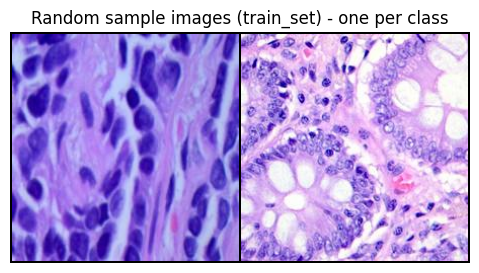

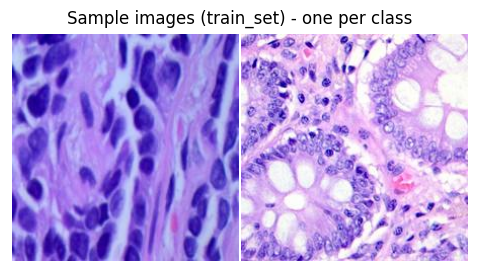

Saved sample grid -> /content/presentation_outputs/sample_images_grid.png
Computing approximate mean/std on train (this may take ~30s)...
Approx dataset mean: [0.6779848  0.559104   0.81245464] std: [0.22348653 0.22448157 0.22989294]
Saved mean/std as CSV.


In [ ]:
# ===========================
# Presentation metrics & EDA
# ===========================
import os, numpy as np, matplotlib.pyplot as plt, torch
import pandas as pd
from collections import Counter
from PIL import Image
import torchvision, seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, roc_curve, auc)

OUTDIR = "/content/presentation_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# ---------- 1) EDA ----------
print("\n=== EDA: class balance & sample images ===")
classes = train_set.classes
print("Classes:", classes)
print("Train counts:", Counter([y for _, y in train_set.samples]))
print("Val   counts:", Counter([y for _, y in val_set.samples]))
print("Test  counts:", Counter([y for _, y in test_set.samples]))

# Sample-grid: one example per class (from train_set)
# Better: Random sample images from each class (fixes duplicate class issue)
from random import choice

samples = []
labels_shown = []

# Build dictionary: class_idx -> all image paths for that class
class_to_paths = {i: [] for i in range(len(classes))}
for path, label in train_set.samples:
    class_to_paths[label].append(path)

# Now pick ONE random example from each class
for cls_idx, cls_name in enumerate(classes):
    if len(class_to_paths[cls_idx]) > 0:
        p = choice(class_to_paths[cls_idx])   # random path from that class
        img = torchvision.io.read_image(p).float() / 255.0
        img = torchvision.transforms.functional.resize(img, (224,224))
        samples.append(img)
        labels_shown.append(cls_name)

# Plot
grid = torchvision.utils.make_grid(samples, nrow=len(samples), normalize=True)
plt.figure(figsize=(3*len(samples), 3))
plt.imshow(grid.permute(1,2,0).numpy())
plt.axis('off')
plt.title("Random sample images (train_set) - one per class")
plt.savefig(os.path.join(OUTDIR, "sample_images_grid.png"), dpi=150, bbox_inches='tight')
plt.show()


if len(samples) > 0:
    grid = torchvision.utils.make_grid(samples, nrow=len(samples), normalize=True, pad_value=1)
    plt.figure(figsize=(3*len(samples),3))
    plt.imshow(grid.permute(1,2,0).numpy())
    plt.axis('off')
    plt.title("Sample images (train_set) - one per class")
    sample_img_path = os.path.join(OUTDIR, "sample_images_grid.png")
    plt.savefig(sample_img_path, bbox_inches='tight', dpi=150)
    plt.show()
    print("Saved sample grid ->", sample_img_path)

# Dataset mean/std (approx using subset)
def compute_mean_std(dataset, n_samples=2000):
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)
    mean = 0.; std = 0.; nb = 0
    for i,(x,_) in enumerate(loader):
        x = x.view(x.size(0), x.size(1), -1)
        mean += x.mean(2).sum(0)
        std  += x.std(2).sum(0)
        nb += x.size(0)
        if nb >= n_samples: break
    mean /= nb; std /= nb
    return mean.numpy(), std.numpy()

print("Computing approximate mean/std on train (this may take ~30s)...")
mean, std = compute_mean_std(train_set, n_samples=2000)
print("Approx dataset mean:", mean, "std:", std)
pd.DataFrame({"mean": mean, "std": std}, index=["R","G","B"]).to_csv(os.path.join(OUTDIR, "dataset_mean_std.csv"))
print("Saved mean/std as CSV.")

In [ ]:
# ---------- 2) Evaluate on test set and compute metrics ----------
print("\n=== Evaluating on test set and computing metrics ===")
model.eval()
softmax = torch.nn.Softmax(dim=1)
all_probs = []
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        probs = softmax(out).cpu().numpy()
        preds = probs.argmax(axis=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Basic metrics
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='binary' if len(classes)==2 else 'macro', zero_division=0)
rec  = recall_score(all_labels, all_preds, average='binary' if len(classes)==2 else 'macro', zero_division=0)
f1   = f1_score(all_labels, all_preds, average='binary' if len(classes)==2 else 'macro', zero_division=0)

# Specificity (binary only)
specificity = None
if len(classes) == 2:
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

print(f"Test Accuracy: {acc:.6f}")
print(f"Precision: {prec:.6f}  Recall: {rec:.6f}  F1: {f1:.6f}  Specificity: {specificity}")
report = classification_report(all_labels, all_preds, target_names=classes, zero_division=0)
print("\nClassification Report:\n", report)
with open(os.path.join(OUTDIR, "classification_report.txt"), "w") as f:
    f.write(report)

# Save metrics summary CSV
metrics_summary = {
    "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "specificity": specificity
}
pd.DataFrame([metrics_summary]).to_csv(os.path.join(OUTDIR, "metrics_summary.csv"), index=False)
print("Saved metrics_summary.csv")



=== Evaluating on test set and computing metrics ===
Test Accuracy: 0.999515
Precision: 1.000000  Recall: 0.994652  F1: 0.997319  Specificity: 1.0

Classification Report:
               precision    recall  f1-score   support

      cancer       1.00      1.00      1.00      3750
      normal       1.00      0.99      1.00       374

    accuracy                           1.00      4124
   macro avg       1.00      1.00      1.00      4124
weighted avg       1.00      1.00      1.00      4124

Saved metrics_summary.csv


In [ ]:
# ===========================================================
# 📌 SINGLE IMAGE PREDICTION
# ===========================================================
from PIL import Image
import numpy as np
from google.colab import files
from torchvision import transforms
import torch # Import torch to use torch.cuda.is_available()

IMG_SIZE = 224 # Add IMG_SIZE definition here
device = "cuda" if torch.cuda.is_available() else "cpu" # Define device here

print("\n📤 Upload images for prediction:")
uploaded = files.upload()

for file in uploaded.keys():
    img = Image.open(file).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)

    pred = model(x).argmax(1).item()
    label = train_set.classes[pred]

    print(f"\n🔍 {file} → PREDICTION: **{label.upper()}**")


📤 Upload images for prediction:


Saving colonca4.jpeg to colonca4 (1).jpeg
Saving colonca8.jpeg to colonca8.jpeg
Saving colonca13.jpeg to colonca13.jpeg
Saving colonca14.jpeg to colonca14.jpeg
Saving colonca23.jpeg to colonca23.jpeg
Saving colonca31.jpeg to colonca31.jpeg
Saving colonca38.jpeg to colonca38.jpeg
Saving colonca45.jpeg to colonca45.jpeg
Saving colonca73.jpeg to colonca73.jpeg
Saving colonca81.jpeg to colonca81.jpeg
Saving colonca229.jpeg to colonca229.jpeg
Saving colonca236.jpeg to colonca236.jpeg
Saving colonca319.jpeg to colonca319.jpeg
Saving colonca320.jpeg to colonca320.jpeg

🔍 colonca4 (1).jpeg → PREDICTION: **CANCER**

🔍 colonca8.jpeg → PREDICTION: **CANCER**

🔍 colonca13.jpeg → PREDICTION: **CANCER**

🔍 colonca14.jpeg → PREDICTION: **CANCER**

🔍 colonca23.jpeg → PREDICTION: **CANCER**

🔍 colonca31.jpeg → PREDICTION: **CANCER**

🔍 colonca38.jpeg → PREDICTION: **CANCER**

🔍 colonca45.jpeg → PREDICTION: **CANCER**

🔍 colonca73.jpeg → PREDICTION: **CANCER**

🔍 colonca81.jpeg → PREDICTION: **CANCER**
